In [1]:
import numpy as np
import pandas as pd
import ipywidgets as w
from ipywidgets import interact
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway, shapiro, kruskal
import matplotlib.pyplot as plt

In [2]:
PATH_TO_DATA = 'data/somascan_171_vs_1305.tsv'

In [3]:
proteins_df = pd.read_csv(PATH_TO_DATA, sep='\t')

### Краткий обзор данных

In [4]:
proteins_df.sample(10)

,ID,Age,Sex,Cohort,A2M,ABL1,ABL2,ACAN,ACE2,ACP1,...,XPNPEP1,XRCC6,YES1,YWHAB,YWHAB.YWHAE.YWHAG.YWHAH.YWHAQ.YWHAZ.SFN,YWHAE,YWHAQ,YWHAZ,ZAP70,ZNRF3
79,721102329,93,Female,GEHA,"4,045","2,275","2,983","2,797","2,697","3,725",...,"4,371","2,262","3,059","4,732","3,951","3,067","3,156","5,291","3,572","2,437"
69,51509071,76,Female,PRIN06,"4,079","2,323","3,068","2,642","2,57","2,775",...,"3,679","2,126","2,621","3,816","2,975","3,107","3,07","4,672","3,743","2,714"
66,42509013,60,Female,PRIN06,"4,637","2,363","3,03","2,592","2,66","3,754",...,"4,15","2,131","2,899","4,574","3,445","3,118","3,144","5,311","3,258","2,688"
28,11500311,65,Female,PRIN06,"3,903","2,401","3,074","2,606","2,78","3,962",...,"3,856","2,225","2,731","4,292","3,243","3,066","2,963","4,966","3,737","2,434"
65,42509001,81,Female,PRIN06,"4,889","2,59","2,992","2,652","2,621","3,154",...,"3,764","2,262","2,776","4,318","3,064","3,014","3,096","5,137","2,936","2,543"
160,60,66,Male,Seattle,"3,919","2,176","2,985","2,662","2,512","3,249",...,"4,148","2,106","2,806","4,495","3,617","3,168","3,021","5,251","3,673","2,519"
100,721125716,93,Male,GEHA,"4,149","2,343","3,159","2,738","2,606","3,698",...,"3,628","2,129","2,707","4,148","3,164","3,223","2,949","4,999","3,798","2,569"
144,44,48,Male,Seattle,"4,251","2,334","2,91","2,681","2,42","2,94",...,"3,929","2,187","2,688","4,101","3,155","3,243","2,899","5,03","3,644","2,449"
39,21000060,102,Male,PRIN06,"4,165","2,427","3,183","2,644","2,561","3,425",...,"3,519","2,448","2,709","3,83","2,832","3,229","2,959","4,389","3,761","2,443"
105,5,75,Female,Seattle,"4,136","2,305","2,943","2,725","2,338","3,246",...,"3,821","2,218","2,669","3,813","2,943","3,173","2,849","4,699","3,677","2,445"


In [5]:
proteins_df.shape

(171, 1309)

In [6]:
proteins_df.dtypes

ID         int64
Age        int64
Sex       object
Cohort    object
A2M       object
           ...  
YWHAE     object
YWHAQ     object
YWHAZ     object
ZAP70     object
ZNRF3     object
Length: 1309, dtype: object

Численные значения в колонках имеют разжделитель - запятую, а не точку. Поэтому, чтобы перевести их в числовой формат, необходимо произвести с ними преобразование:

In [7]:
numeric_columns = proteins_df.columns[4:]

for col in numeric_columns:
    proteins_df[col] = proteins_df[col].apply(lambda x: float(str(x).replace(',', '.')))

In [8]:
proteins_df.dtypes

ID          int64
Age         int64
Sex        object
Cohort     object
A2M       float64
           ...   
YWHAE     float64
YWHAQ     float64
YWHAZ     float64
ZAP70     float64
ZNRF3     float64
Length: 1309, dtype: object

### Посмотрим, есть ли пропущенные значения

In [9]:
proteins_df.isna().sum()

ID        0
Age       0
Sex       0
Cohort    0
A2M       0
         ..
YWHAE     0
YWHAQ     0
YWHAZ     0
ZAP70     0
ZNRF3     0
Length: 1309, dtype: int64

Пропущенных значений нет

## Поиск самых важных признаков, которые изменяются с возрастом

Подбор осуществим с помощью линейной регрессии. Возьмем 5 самых больших по модулю коэффициента и исходя из них определим признаки. При обучении модели будем использовать стандартизированные данные для того, чтобы масштаб изменения признаков был сопоставим. Следовательно, модуль коэффициентов можно будет интерпретировать как значимость соответствующего признака

In [10]:
X = proteins_df[numeric_columns]
X_scaled = StandardScaler().fit_transform(X)
y = proteins_df['Age']

model = LinearRegression()
model.fit(X_scaled, y)

importances = model.coef_
abs_importances = np.abs(importances)

top_5_inds = np.argsort(abs_importances)[-5:]
important_proteins = [numeric_columns[i] for i in top_5_inds]

In [11]:
for prot in important_proteins:
    print(prot)

CST6
RSPO4
NPPB.1
CD63
SOST


Определили пять белков, продукция которых больше всего изменяется с возрастом

### Создадим новый датафрейм, где будут содержаться только отобранные белки

In [12]:
important_proteins_df = proteins_df[['Age', 'Sex'] + important_proteins].copy()

### Определим возрастные группы

In [13]:
age_groups = np.array([[20, 35],                      
                       [36, 55],
                       [56, 70],
                       [71, 90],
                       [91, 120]])

age_groups_names = ['20-35', '36-55', '56-70', '71-90', '91-120']

### Для каждого донора определим его возрастную группу

<AxesSubplot:>

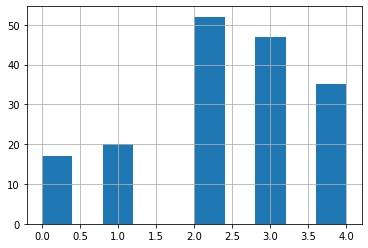

In [14]:
def get_age_group(x):
    x_np = np.array([x])[..., np.newaxis]
    return np.argmax((x_np <= age_groups[:, 1]) * (x_np >= age_groups[:, 0]), axis=1)[0]

important_proteins_df['Age_group'] = important_proteins_df['Age'].apply(get_age_group)
important_proteins_df['Age_group'].hist()

#### Создадим вспомогательный словарь, где для каждого отобранного белка будет содержаться информация о его экспрессии в разбивке по возрастным группам

In [15]:
protein_groups = {f: [np.array(important_proteins_df[f][important_proteins_df['Age_group'] == g]) 
                      for g in range(len(age_groups))] for f in important_proteins}

### Дисперсионный анализ
Проверим статистическую значимость различия средних значений продукции белка между возрастными группами.

In [16]:
# статистический тест ANOVA
for protein in important_proteins:
    print(f'protein {protein} :: p value: {f_oneway(*protein_groups[protein]).pvalue}')

protein CST6 :: p value: 0.00016647724022315688
protein RSPO4 :: p value: 8.454414100217376e-22
protein NPPB.1 :: p value: 3.211847263089088e-25
protein CD63 :: p value: 0.3616525144148982
protein SOST :: p value: 3.8613713269202727e-20


Проверим выполнение критерия применимости ANOVA (нормальность распределения данных внутри сравниваемых выборок) с помощью теста Шапиро-Вилка

In [17]:
print('Normality significance of each group: \n')
for protein in important_proteins:
    group_tests = f'{protein} :: '
    for group in protein_groups[protein]:
        group_tests += str(shapiro(group).pvalue > 0.01) + ' '
    print(group_tests)

Normality significance of each group: 

CST6 :: True True True True True 
RSPO4 :: True True False False True 
NPPB.1 :: True True True True True 
CD63 :: True False False False False 
SOST :: True True True True True 


Не все данные распределены нормально, исходя из теста Шапиро-Вилка. Проводились различные варианты разбиения на группы, однако, ни один из них не позволил добиться нормального распределения во всех группах.
Поэтому, p-value из anova доверять не стоит, и лучше использовать другой тест - Краскела-Уоллеса. Он позволяет работать с данными, распределение которых отлично от нормального. 

In [18]:
# статистический тест Краскела-Уоллеса
p_values = {}
for protein in important_proteins:
    p_value = kruskal(*protein_groups[protein]).pvalue
    print(f'protein {protein} :: p value: {p_value}')
    p_values[protein] = p_value

protein CST6 :: p value: 0.0004297668684308088
protein RSPO4 :: p value: 4.9034477868943947e-17
protein NPPB.1 :: p value: 3.077315816059963e-18
protein CD63 :: p value: 0.018152213878803836
protein SOST :: p value: 7.488194338085093e-12


Низкие значения p.value говорят о статистической значимости различий между возрастными группами для каждого белка.

In [19]:
switch = w.ToggleButtons(options=important_proteins,
                        description='Protein: ',
                        disabled=False,
                        button_style='info',
                        tooltips=important_proteins,
                        layout = w.Layout(display='flex',
                                          flex_flow='column',
                                          align_items='center',
                                          width='80%'))

@interact(protein=switch)
def plot(protein):
    plt.figure(figsize=(12, 9))
    plt.title(f'p-value for protein {protein} is {p_values[protein]:.5f}')
    plt.boxplot(protein_groups[protein])
    plt.xticks(range(1, 6), age_groups_names)
    plt.xlabel('Age groups')
    plt.ylabel('Gene expression')
    plt.show()

interactive(children=(ToggleButtons(button_style='info', description='Protein: ', layout=Layout(align_items='c…